# Unsupervised machine learning techniques

Today we will continue working with the gene expression data of our mice, and try to find patterns in them with the help of unsupervised machine learning algorithms. Unsupervised methods are useful when we have so-called unlabeled data: samples with no group membership information, only their raw values.

Now our expression data isn't unlabeled: we know for every sample 1) what diet it had, 2) what strain it was. But we will not give that information to the upcoming ML methods. We will instead ask these methods to score / separate / cluster the samples based on their raw values only, and then we will verify whether they managed to do it in a way which is consistent with the labels that we had hidden from the algorithms.

The unsupervised techniques we will use today are principal component analysis (PCA), hierarchical clustering and K-means clustering, provided by the feature-rich and easy-to-use `scikit-learn` package. Their website is worth taking a look for anyone interested in machine learning: it's not just a documentation, but also a great guide for a lot of techniques.

In [139]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

## Task 0: Load the expression data

We will need the original raw expression data, and your differential expression analysis csv. Run the below box to make sure we are on the same page.

In [5]:
#xls = pd.read_excel('../data-livermito/aad0189_DataFileS5.xlsx', header=2)
xls = pd.read_excel('Day2_Files\\aad0189_DataFileS5.xlsx', header = 2)
#xls = xls['Generated on Affymetrix Mouse Gene 1.0 ST platform']
expr = xls.groupby('Gene.1').mean()  # or 'Gene' if you had used that for your DE calculations
expr = expr.loc[:, expr.columns.str.contains('Liver')]
is_hfd = pd.Series(expr.columns.str.contains('HFD'), index=expr.columns)  # diet labels for verification
is_hfd.name = 'is_HFD'


In [6]:
is_hfd.head()

C57BL/6J_Liver_CD    False
DBA/2J_Liver_CD      False
BXD43_Liver_CD       False
BXD44_Liver_CD       False
BXD45_Liver_CD       False
Name: is_HFD, dtype: bool

In [7]:
genes_df = pd.read_csv('Day2_Files\\p_val_dat.csv')
# load your differential expression summary csv from Day 5 for later use. (log2folds, p-values etc)

Since `scikit-learn` likes to treat data as one sample per row, we should transpose our expression data matrix, such that rows stand for mice and columns stand for genes. Let's call the transposed form of `expr` as `data`.

In [8]:
data = expr.T
display(data.head())

Gene.1,544988,100043387,0610007C21Rik,0610007L01Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,mCG_21548,rp9
C57BL/6J_Liver_CD,6.183000,10.384,12.389,10.2875,8.116,12.281,8.364,9.440,7.033,10.904,...,9.104,8.152,10.427,9.668,9.903,10.175,6.939,9.885,7.335,9.943
DBA/2J_Liver_CD,6.353333,9.848,12.559,10.3900,8.422,12.305,8.257,8.576,7.126,10.949,...,9.087,7.754,10.162,9.411,9.565,10.361,7.398,9.945,7.801,9.795
BXD43_Liver_CD,6.262333,10.108,12.647,10.4110,8.235,11.949,8.578,8.264,7.374,11.024,...,9.330,7.616,10.062,9.576,9.650,10.231,7.447,10.123,7.789,9.860
BXD44_Liver_CD,6.263667,9.860,12.639,10.4195,8.135,11.895,8.539,8.815,7.325,10.665,...,9.058,7.292,10.233,9.685,9.721,10.146,7.552,9.319,7.708,9.715
BXD45_Liver_CD,6.270000,9.392,12.515,10.3060,8.198,12.160,8.298,9.418,7.526,10.669,...,8.847,7.756,10.173,9.603,9.687,10.261,7.600,9.510,7.703,9.772


## Task 1: Principal component analysis
PCA takes a set of high-dimensional samples (vectors), and transforms them to lower dimensional vectors using a linear transformation. Based on the data, it finds an optimal list of unit length vectors (called principal directions) and "projects" the data onto these principal directions with a simple dot product (aka a weighted sum). You can think about these principal directions as weight vectors, and the principal component scores as the weighted sums that they produce on your data.

The strength of PCA is in how it chooses these principal directions. The first principal direction is the unit length weight vector that maximizes the variance of the weighted sums when applied on your input vectors. The second principal direction is guaranteed to be orthogonal to the first one (i.e. uncorrelated with it) and also maximizes the variance of the output under this constraint. The third one is orthogonal to both the first and the second... and so on.

Usually the first few principal components "explain most of the variance" in your data: the corresponding principal directions have large weights in the dimensions where your data shows a lot of variance, and low weights elsewhere. The orthogonality (uncorrelatedness) of the principal directions guarantees that they capture new sources of variance with each additional step.

Of course PCA is a deep topic and requires a good grasp on linear algebra to understand it in detail, but there are plenty of online resources and textbooks that can help you with that if you're interested. A rough understanding and some hands-on examples can still take us a long way.

### 1.1: Initialize a PCA object with 4 components and transform your data
Browse `scikit-learn`'s documentation to see how.

In [9]:
pca = PCA(n_components=4)
components = pca.fit_transform(data)
print(components)

[[  3.9794303   24.78198809  -4.28769732   9.01995819]
 [-16.03223309   2.59873672  -6.82282751  10.74038815]
 [-12.57180397   3.01122861   5.40760444  -5.0028268 ]
 [ -5.30687878 -12.66433814  13.07557628 -12.61953379]
 [-22.29496543  -6.99628166   1.74583709  10.95128097]
 [-15.51869253  -1.0520451    6.20330756  -9.09991969]
 [ -4.87325165  18.930147     6.64732602   2.55355408]
 [-22.12540971  -6.72199591   6.13208514   8.73046419]
 [-18.7499836   -0.868409     1.43847572   0.15165762]
 [-19.04324904  -1.56505676   0.9992658    5.8258845 ]
 [  8.57367757  13.07038679   8.37330234  -6.02002864]
 [ 19.94155209  13.56821289  47.99197462  28.49419417]
 [-10.49888868   2.27970788   8.3708044   -4.22108371]
 [ -8.90670749   1.13786348  -9.94487372   9.05036649]
 [ -5.06991069  12.62269069  -1.1972355   -4.2925782 ]
 [ -3.62777822   3.2056701    5.11298791  -8.16857608]
 [ -8.21197576   6.09173982  -3.08528122  -7.46689138]
 [ -5.35859221  12.5926776   -5.90774588   2.90502748]
 [ -7.7700

### 1.2: Plot the principal components against each other

Plotting the first principal component against the second is simple enough with matplotlib's `scatter`, but we can do better and create a scatter plot for each pair using seaborn's `pairplot`. This requires your data to be a `DataFrame`, but you know how to turn a numpy matrix into a DF. Add the proper row indices while you're at it.

In [10]:
comp_df = pd.DataFrame(components, index = data.index)
comp_df.head()

,0,1,2,3
C57BL/6J_Liver_CD,3.979430,24.781988,-4.287697,9.019958
DBA/2J_Liver_CD,-16.032233,2.598737,-6.822828,10.740388
BXD43_Liver_CD,-12.571804,3.011229,5.407604,-5.002827
BXD44_Liver_CD,-5.306879,-12.664338,13.075576,-12.619534
BXD45_Liver_CD,-22.294965,-6.996282,1.745837,10.951281


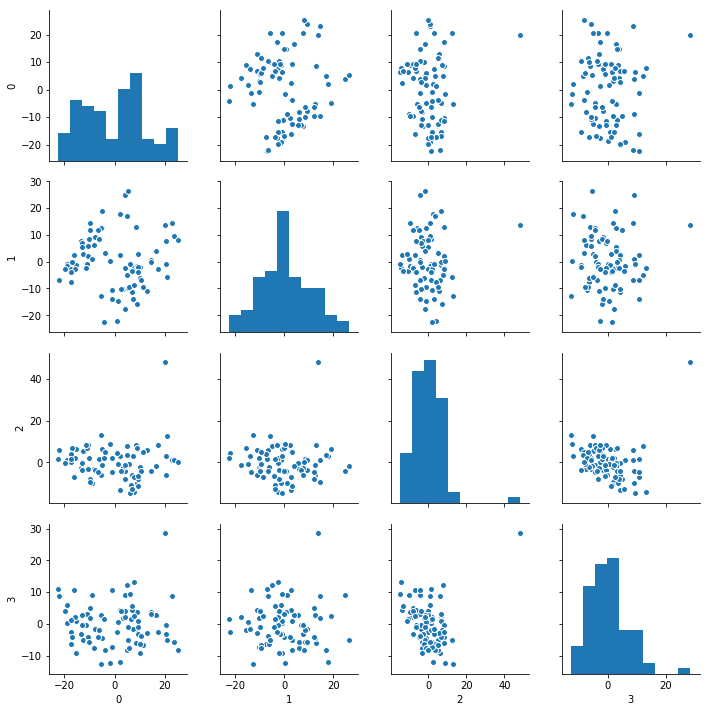

In [11]:
sns.pairplot(comp_df)

### 1.2.1: Add color information based on the diet
`sns.pairplot` can color points based on the values of a column specified by `hue` keyword, so add an `is_HFD` column to the principal component matrix. PCA of course did not use the color labels, you only added them afterwards. In light of this, do you find the plots impressive?

,0,1,2,3,is_HFD
C57BL/6J_Liver_CD,3.979430,24.781988,-4.287697,9.019958,False
DBA/2J_Liver_CD,-16.032233,2.598737,-6.822828,10.740388,False
BXD43_Liver_CD,-12.571804,3.011229,5.407604,-5.002827,False
BXD44_Liver_CD,-5.306879,-12.664338,13.075576,-12.619534,False
BXD45_Liver_CD,-22.294965,-6.996282,1.745837,10.951281,False


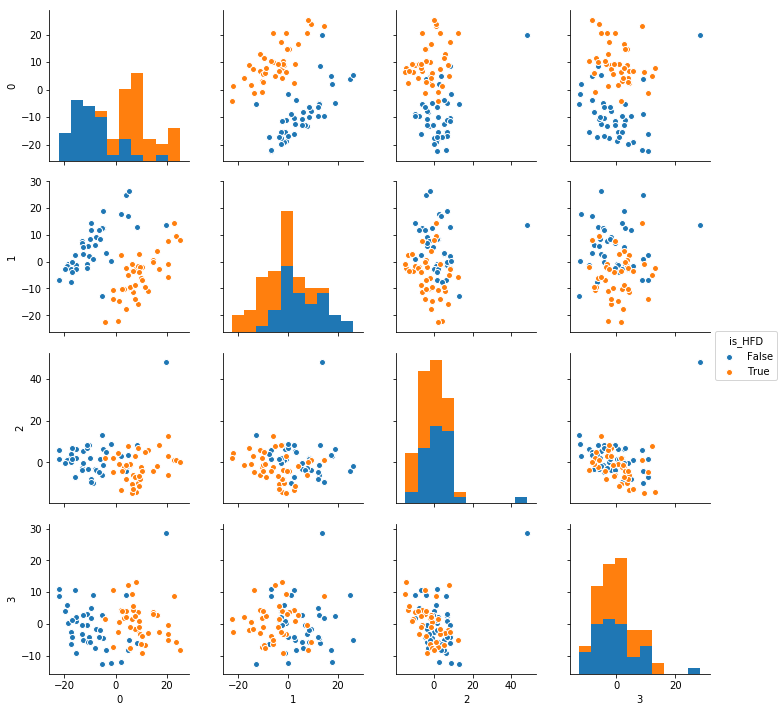

In [12]:
comp_df_hfd = comp_df.copy()
comp_df_hfd['is_HFD'] = is_hfd
sns.pairplot(comp_df_hfd, hue = 'is_HFD', vars = [0,1,2,3])
comp_df_hfd.head()

Information from the first and the second component is sufficient to seperate between the diets. This can be seen when looking at the scatterplot of first vs. second component. Mice with a high first and a low second component have a high fat diet (HFD) and vice versa for mice with a CD.

### 1.2.2: Optional: use every 200th gene only. Is the PCA plot still informative?
If you choose to do this task, make sure not to overwrite the original results using all the data. We will return to using the full data after this optional subtask.

### 1.3: Find the principal directions of the fitted PCA. Are they orthogonal and unit length as promised?
Confusingly, `scikit-learn` (and unfortunately a lot of people as well) like to call the principal directions as "principal components", overloading the term, since it is already used to refer to the transformed values as well. A brief discussion here: https://stats.stackexchange.com/questions/88118/what-exactly-is-called-principal-component-in-pca

Anyway, you will find the principal direction vectors in `pca.components_`.

In [13]:
dot_prod = np.dot(pca.components_, pca.components_.T)
#plt.imshow(dot_prod)
#plt.show()
#plt.imshow(dot_prod, interpolation='nearest')
#plt.show()

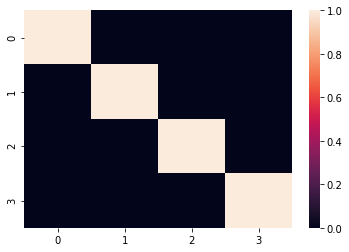

In [14]:
sns.heatmap(dot_prod)
#plt.imshow(dot_prod)
#plt.show()
#plt.legend()

### 1.4: How correlated are the transformed values (principal component scores) with each other? Why is it important?

In [15]:
cor = comp_df.corr(method = 'pearson')

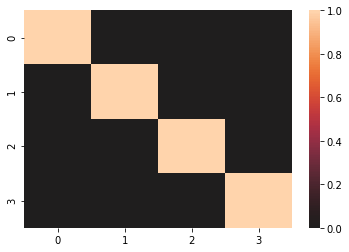

In [16]:
sns.heatmap(cor, center = 0)

### 1.5: Compare the first principal direction's weights with the log-fold-change vector from your differential expression analysis. Visualize them on a scatter plot, and interpret what you see.
Remember, you had computed the fold-change values by comparing expression values between CD and the HFD diets. PCA had no access to the diet information, and yet...

You can also try a scatter plot for weight vs p-values, log10-p, etc. Some of them might look familiar.

Tip: turn the matrix containing the principal direction vectors into a DataFrame, and add the gene indices. This will make your life easier.

In [17]:
genes_df.head()

,Gene.1,log2fc,p_val,p_corr,p_val_log,p_val_corr_log
0,544988,-0.040208,0.026537,0.054807,1.576142,1.261166
1,100043387,-0.090000,0.118846,0.190697,0.925016,0.719657
2,0610007C21Rik,-0.014575,0.510414,0.610010,0.292078,0.214663
3,0610007L01Rik,0.005400,0.769022,0.830732,0.114061,0.080539
4,0610007P08Rik,-0.062063,0.059674,0.107970,1.224216,0.966698


In [18]:
pca.components_

array([[ 0.00087089,  0.0095567 , -0.00105985, ...,  0.0064474 ,
        -0.00414989, -0.00190494],
       [-0.00212986,  0.01020377, -0.0039148 , ...,  0.00535427,
        -0.00972976,  0.00380099],
       [-0.00076576, -0.00115791,  0.00195479, ..., -0.0099968 ,
        -0.00226992, -0.00584466],
       [ 0.00022603, -0.00633633, -0.00480402, ..., -0.00149347,
        -0.00132776, -0.00840805]])

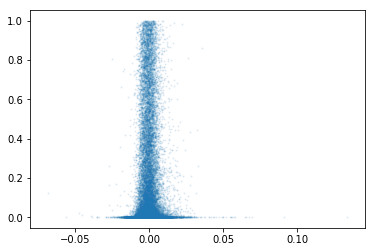

In [19]:

plt.scatter(pca.components_[0],genes_df['p_val'], s = 1, alpha = 0.1)


(-0.05, 0.05)

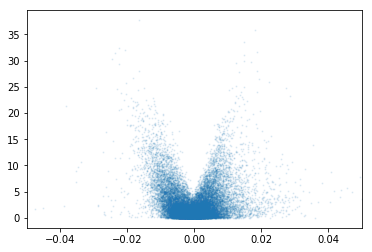

In [20]:
plt.scatter(pca.components_[0],genes_df['p_val_log'], s = 1, alpha = 0.1)
plt.xlim([-0.05, 0.05])

The volcano plot can be reproduced using the first component on the x-axis instead of log2fc...


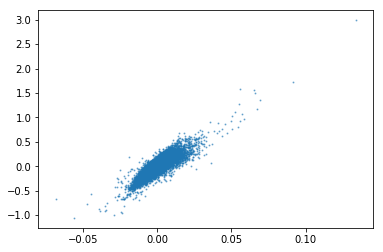

In [21]:
plt.scatter(pca.components_[0],- genes_df['log2fc'], s = 1, alpha = 0.5)

There is a clear correlation between log2fc and the first component.
That also explains why the volcanon plot can be created using the first component instead of log2fc

### 1.6: Create a scatter plot for PC1 vs PC2 only, but this time connect pairs of points that come from the same strain

This will involve `plt.scatter`, and a `for` loop with `plt.plot` calls. Watch out, not every strain has both CD and HFD expression measurements: some points will be orphans.

The pattern of the resulting lines could be interesting. If it is, try to explain why.

(Optional, for those finishing early, or looking for extra tasks: how would you formulate your observation in mathematical terms, and do you see this effect in other principal components?)

In [22]:
comp_df.head()


,0,1,2,3
C57BL/6J_Liver_CD,3.979430,24.781988,-4.287697,9.019958
DBA/2J_Liver_CD,-16.032233,2.598737,-6.822828,10.740388
BXD43_Liver_CD,-12.571804,3.011229,5.407604,-5.002827
BXD44_Liver_CD,-5.306879,-12.664338,13.075576,-12.619534
BXD45_Liver_CD,-22.294965,-6.996282,1.745837,10.951281


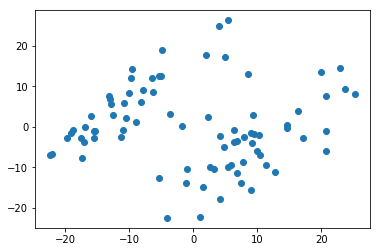

In [196]:
plt.scatter(comp_df[0], comp_df[1])

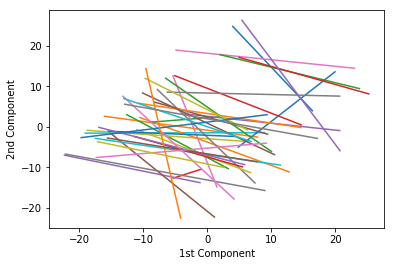

In [23]:
from collections import Counter
#pc_df = comp_df
strain_counts = Counter([x.split('_')[0] for x in data.index])
tmp_for_correlation_cmp1 = []
tmp_for_correlation_cmp2 = []
for strain, count in strain_counts.items():
    id1 = strain + '_Liver_CD'
    id2 = strain + '_Liver_HFD'
    if count == 2 :
        plt.plot(comp_df.loc[[id1,id2],0], comp_df.loc[[id1,id2],1])
        tmp_for_correlation_cmp1.append([comp_df.loc[id1,0],comp_df.loc[id2,0]])
        tmp_for_correlation_cmp2.append([comp_df.loc[id1,1],comp_df.loc[id2,1]])
    plt.xlabel('1st Component')
    plt.ylabel('2nd Component')

The second principal component seems to be very dependant on the identity of the mouse and not on its diet. This can be deducted from the parallelity of the lines.
However the analysis below tells a different story...


[[1.         0.41701974]
 [0.41701974 1.        ]]


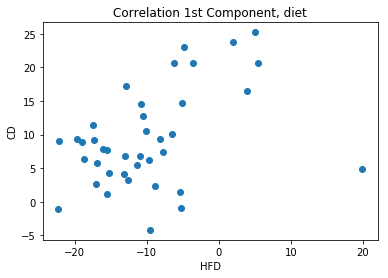

In [24]:
#With help of Andres:
xxx=np.array(tmp_for_correlation_cmp1)
plt.scatter(xxx[:,0], xxx[:,1])
plt.ylabel('CD')
plt.xlabel('HFD')
plt.title('Correlation 1st Component, diet')
print(np.corrcoef(xxx[:,0], xxx[:,1]))

[[1.         0.37847624]
 [0.37847624 1.        ]]


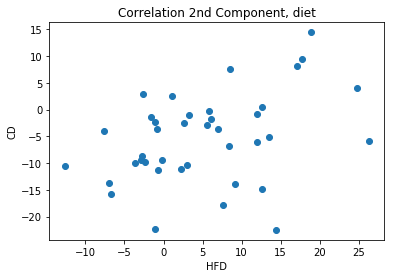

In [25]:
#With help of Andres:
xxx=np.array(tmp_for_correlation_cmp2)
plt.scatter(xxx[:,0], xxx[:,1])
plt.ylabel('CD')
plt.xlabel('HFD')
plt.title('Correlation 2nd Component, diet')
print(np.corrcoef(xxx[:,0], xxx[:,1]))

Correlation analysis:

If for the analysed component the two diets correlate highly, the component is more independent of the diet, the more the values for the two diets correlate.
We would expect a low correlation for component 1, as component 1 correlates highly to the diet and a low correlation for component 2, as we think that component 2 is rather independent of the diet.

However as you can see both correlations are in the same orders of magnitude, the corrcoef for component 1 even being higher.

Maybe there is a mistake in this analysis, but I will leave it here anyways.

Probably information of both first AND second component are required to infer the diet.

## Task 2: Hierarchical clustering

You had created a cluster-map before with dendrograms on the top and left edges of the figure. They are a result of an unsupervised technique called hierarchical clustering. It iteratively merges single data points into bigger and bigger clusters based on their similarity, one at a time, until all points belong to one big cluster. Seaborn's `clustermap` does it on both axes by default, and produces a heatmap of the values as well.

### 2.1: Create a clustermap
From your first PCA direction vector, take the genes with the 15 largest positive, and 15 largest negative weights, and create a smaller expression matrix with these 30 genes only. Use seaborn's `clustermap` to display a heatmap and a hierarchical clustering of genes and mice.


### 2.2: Display the diet as color labels on the corresponding dendrogram
You will have to convert `is_hfd`'s boolean values to color values first: `y` or `yellow` for `True` and `b` or `blue` for `False` should do fine.

In [42]:
pca_dir = pd.DataFrame(pca.components_, columns = expr.index)
pca_dir = pca_dir.T
pca_dir.head()

,0,1,2,3
Gene.1,,,,
544988,0.000871,-0.002130,-0.000766,0.000226
100043387,0.009557,0.010204,-0.001158,-0.006336
0610007C21Rik,-0.001060,-0.003915,0.001955,-0.004804
0610007L01Rik,-0.002615,-0.003060,-0.002534,-0.000280
0610007P08Rik,0.003394,0.003273,-0.006968,0.000349


In [100]:
pca_dir1 = pca_dir[0]
chosen_genes = []
chosen_genes.append(pca_dir1.sort_values()[0:15].index.tolist())
chosen_genes.append(pca_dir1.sort_values(ascending=False)[0:15].index.tolist())
chosen_genes = np.array(chosen_genes)
chosen_genes = chosen_genes.flatten()
#pca_dir1_chosen = pca_dir1[chosen_genes]
data_chosen = data[list(chosen_genes)]
data_chosen.head()
#chosen_genes



Gene.1,Hsd3b5,Serpina4-ps1,Moxd1,Slco1a1,Hamp,Srgap3,Agxt2l1,Gpr110,Csad,Ces6,...,Cyp2b13,Lgals1,Cd36,D630002G06Rik,Saa1,9030619P08Rik,Orm2,Cyp2a22,Orm3,Ly6d
C57BL/6J_Liver_CD,12.584,12.694,9.765,12.783,14.318,8.2065,11.288,9.841,11.565,11.429,...,5.299,11.024,10.116,6.502,12.354,9.732,13.928,7.369,10.429,8.747
DBA/2J_Liver_CD,12.906,13.400,11.844,13.100,14.529,8.4410,11.388,9.165,11.799,11.179,...,5.460,9.575,9.549,6.806,7.294,8.810,9.716,7.327,8.064,8.149
BXD43_Liver_CD,10.141,10.677,10.823,12.954,13.476,7.8515,12.873,9.222,11.185,10.797,...,5.133,9.416,10.135,6.352,7.435,7.735,10.452,7.169,8.750,8.918
BXD44_Liver_CD,5.995,7.625,7.275,8.884,11.178,7.7255,11.077,7.185,10.648,9.746,...,7.184,12.808,12.681,7.431,10.699,10.251,12.602,11.327,10.776,11.487
BXD45_Liver_CD,12.899,12.339,8.390,13.162,14.518,8.5050,12.132,9.710,11.731,11.054,...,5.223,9.668,9.063,6.764,6.445,7.793,9.788,7.224,8.290,8.406


In [114]:

is_hfd_col = is_hfd.astype('str').str.replace('True', 'y').replace('False', 'b')
#is_hfd_col = is_hfd.replace(True, 'y').replace.replace(False, 'b')
#pd.concat([data_chosen, is_hfd_col])
data_chosen['is_hfd'] = is_hfd_col
data_chosen.head()
#data_chosen['is_hfd']
data_chosen_plot = data_chosen.drop(columns ='is_hfd')


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [118]:
def convert_to_color(col_names,c_CD, c_HFD):
    out_color = []
    for en in col_names:
        if 'CD' in en:
            out_color.append(c_CD)
        elif 'HFD' in en:
            out_color.append(c_HFD)
        else:
            #out_color.append(c_HFD)
            print('Could not assign color')
        
    return out_color

colors = convert_to_color(data_chosen.index.tolist(), 'b', 'y')

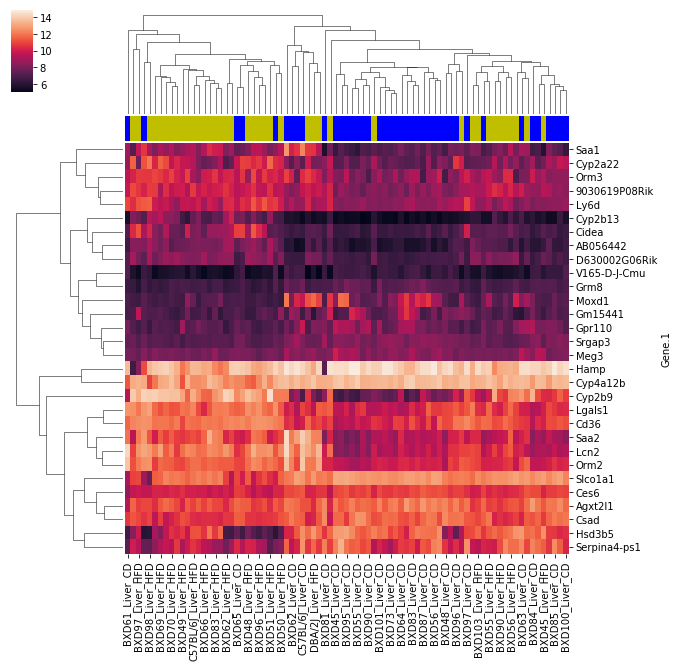

In [120]:
#sns.clustermap(data_chosen.T, col_colors = is_hfd_col[data_chosen.index].values)
sns.clustermap(data_chosen.drop(columns ='is_hfd').T, col_colors = colors)#data_chosen['is_hfd']

In [124]:
data_chosen = data_chosen.drop(columns = 'is_hfd')

ValueError: labels ['is_hfd'] not contained in axis

### 2.3: Standardize the matrix
Like we saw yesterday, it is hard to see the fine differences between the gene expression levels across mice, because the range of general expression levels across genes is much higher. To circumvent this, we standardize our data: for every gene, subtract the mean and optionally divide by the standard deviation.

You can do this with yesterday's pandas one-liner, or use sklearn's `StandardScaler` tool. You can simply extend Task 2.2 in the above cell with this and overwrite the previous clustermap.

In [127]:

data_chosenT = data_chosen.T
dat_norm = data_chosenT.subtract(data_chosenT.median(axis = 1), axis = 0).divide(data_chosenT.std(axis = 1), axis = 0)


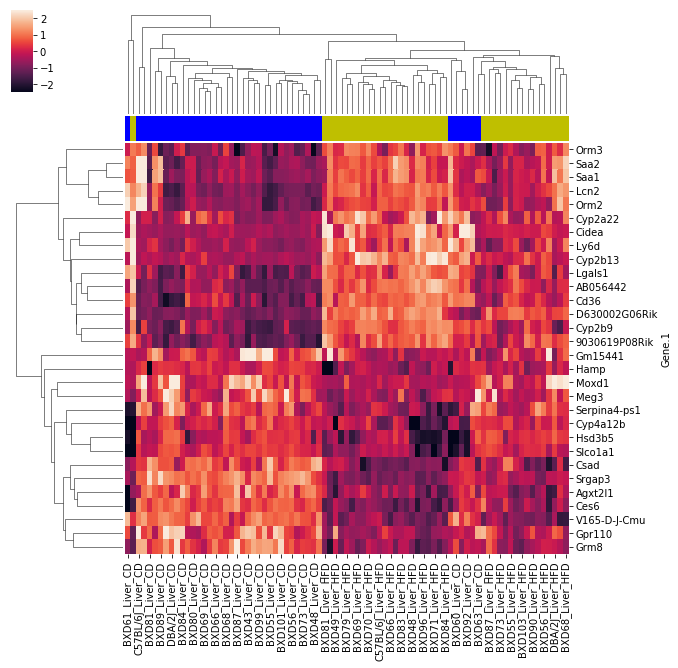

In [134]:
sns.clustermap(dat_norm, col_colors = colors, vmin = -2.5, vmax = 2.5)#data_chosen['is_hfd']

In [133]:
dat_norm

,C57BL/6J_Liver_CD,DBA/2J_Liver_CD,BXD43_Liver_CD,BXD44_Liver_CD,BXD45_Liver_CD,BXD48_Liver_CD,BXD49_Liver_CD,BXD51_Liver_CD,BXD55_Liver_CD,BXD56_Liver_CD,...,BXD89_Liver_HFD,BXD90_Liver_HFD,BXD95_Liver_HFD,BXD96_Liver_HFD,BXD97_Liver_HFD,BXD98_Liver_HFD,BXD99_Liver_HFD,BXD100_Liver_HFD,BXD101_Liver_HFD,BXD103_Liver_HFD
Gene.1,,,,,,,,,,,,,,,,,,,,,
Hsd3b5,0.751173,0.912748,-0.474689,-2.555093,0.909236,-1.387438,0.158564,0.696479,0.317129,0.416482,...,0.362289,0.179138,0.357271,-2.205850,-0.587089,-2.502406,0.321645,-0.385873,-1.838041,0.316627
Serpina4-ps1,1.729943,2.237354,0.280298,-1.913215,1.474800,0.263049,0.577845,0.907735,0.985356,1.427365,...,-0.226395,0.639655,0.439134,-0.730213,-0.580002,-2.007366,-1.096038,0.362231,-0.879705,-0.522505
Moxd1,1.580933,2.924661,2.264754,-0.028439,0.692224,0.019390,-0.117633,0.277277,0.539689,1.090365,...,-0.014866,-0.190022,2.197535,-0.261765,-0.459543,-0.315411,0.403312,-0.354837,-0.349667,-0.455019
Slco1a1,0.403498,0.700961,0.563959,-3.255198,0.759140,-0.089145,0.304031,0.640905,0.442910,0.648412,...,0.330305,0.271188,-0.425081,-1.557691,-1.180467,-4.362472,-0.033781,-0.183920,-1.026574,0.142632
Hamp,0.210641,0.358791,-0.380557,-1.994064,0.351068,0.231705,0.004915,0.613666,0.595411,0.560304,...,-1.072160,-0.549070,0.433217,-0.701433,-3.998660,-0.340536,-1.403568,-0.418473,-0.468324,0.342642
Srgap3,0.860845,1.284937,0.218828,-0.009042,1.400681,0.640208,0.342710,0.878026,1.843763,1.480255,...,-0.199839,-0.175424,-0.170903,-1.284937,-1.109513,-1.110417,-0.785792,-0.642017,-0.925046,-0.136542
Agxt2l1,-0.360439,-0.209628,2.029921,-0.678651,0.912409,1.330156,0.568559,1.109972,0.138746,1.379924,...,-0.680159,-1.384448,-1.827834,-0.969717,-1.027025,-0.651505,-0.720878,-0.660554,-0.426796,-0.827954
Gpr110,2.775938,1.964289,2.032727,-0.413029,2.618651,0.618343,1.799797,1.844222,0.374608,0.452651,...,-0.032418,0.720399,0.000000,-1.137030,-1.026569,-1.247491,-0.122468,-0.889693,-0.660366,-0.707192
Csad,0.447528,0.778925,-0.090639,-0.851153,0.682622,1.727797,1.951561,1.074917,2.049281,1.131566,...,-1.461547,-0.858234,-2.073357,-0.963035,-0.236510,-0.288910,-1.346832,-0.887975,-0.834158,-0.273332


### 2.4: Try different linkage methods
The linkage method defines how cluster similarities are defined. For example, `single` defines the distance of two clusters as the smallest distance of any two elements between them. Its opposite is `complete` which takes the largest distance of any two elements across two clusters. Between these two extremes are `centroid`, `average`, and a few more. Look at how they affect the topology of the clusters. Which one seems most suitable in our case?

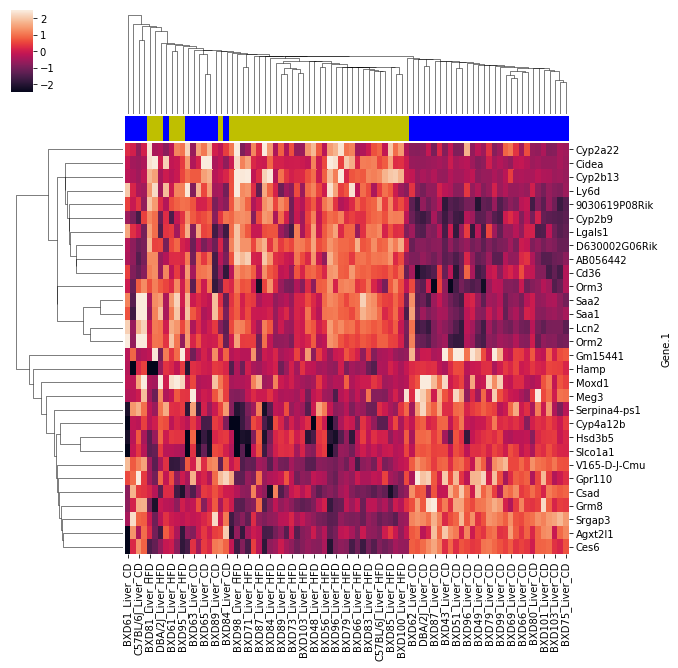

In [137]:
'''SINGLE'''
sns.clustermap(dat_norm, col_colors = colors, method = 'single', vmin = -2.5, vmax = 2.5)

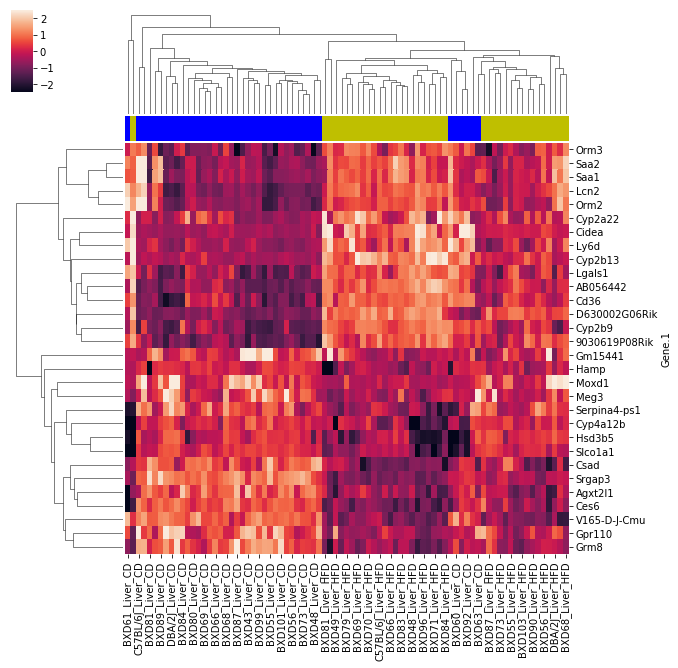

In [138]:
'''AVERAGE'''
sns.clustermap(dat_norm, col_colors = colors, method = 'average', vmin = -2.5, vmax = 2.5)

## Task 3: K-means clustering

K-means clustering attempts to create `k` virtual samples, whose average distances to the nearest actual samples is as small as possible. These `k` virtual samples are called cluster centers/prototypes or centroids. Each sample is assigned to the nearest centroid, therefore partitioning the samples to k clusters.

### 3.1: Perform k-means clustering on the expression dataset. What k should you choose?

In [178]:
'''
dat_norm = dat_norm.drop(columns ='is_hfd')
res = KMeans(n_clusters=2, random_state=0).fit(dat_norm)
res_lab = pd.Series(res.labels_)
#is_hfd
dat_norm['is_hfd'] = is_hfd
#is_hfd
display(pd.crosstab(res_lab, dat_norm['is_hfd']))
'''

""


In [193]:
#dat_norm = dat_norm.drop(columns ='is_hfd')
res2 = KMeans(n_clusters=2, random_state=0).fit(data)
#res_lab = pd.Series(res.labels_)
#is_hfd
#dat_norm['is_hfd'] = is_hfd

### 3.2: Compare the resulting clusters with the diet labels
Tip: remember `crosstab`? You can concatenate the cluster labels with the diet information and cross-tabulate them.

Optional: try higher k-values, and investigate the resulting clusters.

In [194]:
pd.crosstab(res2.labels_, is_hfd)

is_HFD,False,True
row_0,,
0,40,0
1,1,40


For two centromers the clusters were set according to diet.

In [195]:
res4 = KMeans(n_clusters=4, random_state=0).fit(data)
pd.crosstab(res4.labels_, is_hfd)

is_HFD,False,True
row_0,,
0,0,29
1,22,0
2,18,1
3,1,10


for 4 centromers 4 clusters are found. These also identify the two diets and probably seperate between the positive or negative effect on gene expression.

### 3.3: With k=2, take the centroids, and transform them with the same PCA that you had trained earlier. Highlight them on the PC1 vs PC2 plot.
Before doing this, think about where you would expect them to fall. Did they?

In [204]:
np.shape(res2.cluster_centers_)
#TRasform the 21000 dim centroids with pca to two dimensions
res_transform = pca.transform(res2.cluster_centers_)
res_transform

array([[-9.90981473,  4.95693909,  1.26671741, -1.25388808],
       [ 9.66811193, -4.83603814, -1.23582186,  1.22330544]])

Text(0.5,1,'Two Centroid k-mean analysis')

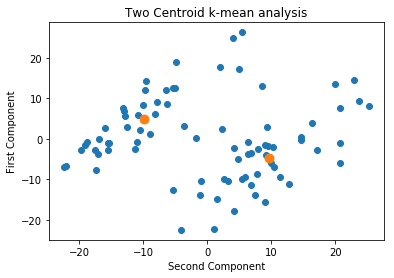

In [212]:
plt.scatter(comp_df[0], comp_df[1])
plt.scatter(res_transform[:,0], res_transform[:,1], s = 80)
plt.ylabel('First Component')
plt.xlabel('Second Component')
plt.title('Two Centroid k-mean analysis')

Text(0.5,1,'Two Centroid k-mean analysis')

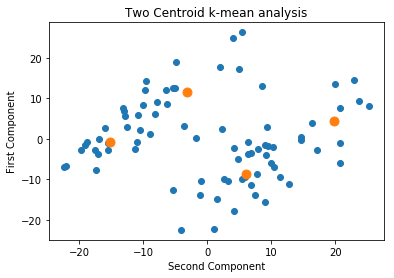

In [213]:
np.shape(res4.cluster_centers_)
#TRasform the 21000 dim centroids with pca to two dimensions
res4_transform = pca.transform(res4.cluster_centers_)
res4_transform
plt.scatter(comp_df[0], comp_df[1])
plt.scatter(res4_transform[:,0], res4_transform[:,1], s = 80)
plt.ylabel('First Component')
plt.xlabel('Second Component')
plt.title('Two Centroid k-mean analysis')

### 3.4: Train a 2-means clustering on every second sample and predict on the other half of the samples
Since the CD and HFD samples form two contiguous batches in our matrix, you can just use `::2` and `1::2` to split them evenly. What do you find?

In [225]:
res_splt = KMeans(n_clusters=2, random_state=0).fit(data[::2])
display('Training dataset:')
display(pd.crosstab(res_splt.labels_, is_hfd[::2]))
res_splt_pred = res_splt.predict(data[1::2])
display('Predicted dataset:')
display(pd.crosstab(res_splt_pred, is_hfd[1::2]))
#display('Training and predicted cumulated:')
#display(pd.crosstab(np.array([res_splt_pred,res_splt.labels_]).flatten() , is_hfd))


'Training dataset:'

is_HFD,False,True
row_0,,
0,21,0
1,0,20


'Predicted dataset:'

is_HFD,False,True
row_0,,
0,19,0
1,1,20


For 2 ks the prediction is perfect. However for more ks I would expect the prediction to deviate from the above result, where we used the whole dataset for training, as in this case we only use half the dataset for training and thus the centromers created by half the dataset are probably more inaccurate than those that were created using the whole dataset.

In [227]:
res_splt4 = KMeans(n_clusters=4, random_state=0).fit(data[::2])
display('Training dataset:')
display(pd.crosstab(res_splt4.labels_, is_hfd[::2]))
res_splt_pred4 = res_splt4.predict(data[1::2])
display('Predicted dataset:')
display(pd.crosstab(res_splt_pred4, is_hfd[1::2]))

'Training dataset:'

is_HFD,False,True
row_0,,
0,15,0
1,1,4
2,0,16
3,5,0


'Predicted dataset:'

is_HFD,False,True
row_0,,
0,18,0
1,1,5
2,0,14
3,1,1


In case of k = 4 we have a higher deviation.
However we did not really verify the data yet. The deviation could also be due to the fact that when splitting the data by chance, more Strains that belong to a certain cluster was in the training dataframe than in the prediction dataframe.
However the deviation could also be caused by the fact, that the training dataset was too small and thus the placement of the centromeres was too inaccurate